训练集大小: (10132, 52), 测试集大小: (21120, 52)
原始训练集大小: (10132, 52), 增强后训练集大小: (10560, 52)
使用设备: cuda
Epoch [1/40], Train Loss: 2.1771, Train Accuracy: 31.16%
Epoch [1/40], Val Loss: 2.0129, Val Accuracy: 32.81%
Epoch [2/40], Train Loss: 1.7606, Train Accuracy: 42.32%
Epoch [2/40], Val Loss: 1.6014, Val Accuracy: 48.58%
Epoch [3/40], Train Loss: 1.5342, Train Accuracy: 49.87%
Epoch [3/40], Val Loss: 1.4565, Val Accuracy: 51.47%
Epoch [4/40], Train Loss: 1.3520, Train Accuracy: 55.57%
Epoch [4/40], Val Loss: 1.2208, Val Accuracy: 62.22%
Epoch [5/40], Train Loss: 1.2259, Train Accuracy: 59.59%
Epoch [5/40], Val Loss: 1.1444, Val Accuracy: 62.69%
Epoch [6/40], Train Loss: 1.1298, Train Accuracy: 62.36%
Epoch [6/40], Val Loss: 1.1121, Val Accuracy: 63.64%
Epoch [7/40], Train Loss: 1.0705, Train Accuracy: 64.00%
Epoch [7/40], Val Loss: 1.0013, Val Accuracy: 67.38%
Epoch [8/40], Train Loss: 0.9964, Train Accuracy: 66.60%
Epoch [8/40], Val Loss: 0.9641, Val Accuracy: 67.38%
Epoch [9/40], Train Loss: 

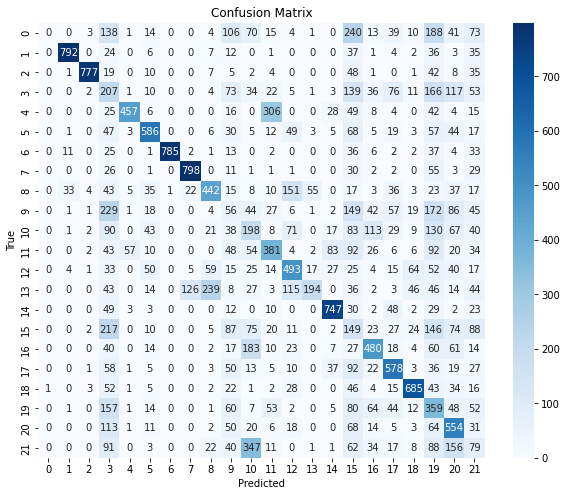

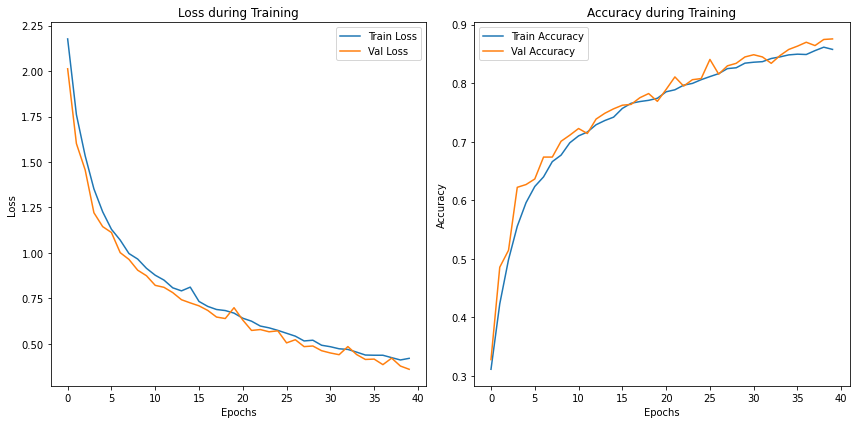

In [1]:
# 导入必要的库
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据函数，加载指定文件夹内的数据文件，并按顺序合并
def load_te_data(folder_path):
    data = []  # 存储数据
    labels = []  # 存储标签
    files = sorted(os.listdir(folder_path))  # 保证文件顺序一致
    for file in files:
        if file.endswith('.dat'):  # 只处理以 '.dat' 结尾的文件
            file_path = os.path.join(folder_path, file)
            # 读取文件，假设是空格分隔的数据
            df = pd.read_csv(file_path, sep='\\s+', header=None)
            # 提取标签（假设标签位于文件名中）
            label = int(file[1:3])  # 从文件名中提取标签，例如 'd00.dat' 提取 '00'
            data.append(df)  # 添加数据
            labels.append(np.full((df.shape[0],), label))  # 添加对应的标签
    # 合并所有数据和标签
    return pd.concat(data, axis=0), np.concatenate(labels, axis=0)

# 加载训练集和测试集数据
train_data, train_labels = load_te_data('TE_train')
test_data, test_labels = load_te_data('TE_test')

# 将标签添加到数据中，方便后续操作
train_data['Label'] = train_labels
test_data['Label'] = test_labels

# 确保训练集和测试集特征对齐，去除标签列进行对比
common_columns = train_data.columns.intersection(test_data.columns).drop('Label')
train_data = train_data[common_columns.to_list() + ['Label']]
test_data = test_data[common_columns.to_list() + ['Label']]

# 数据标准化：为了后续模型训练，确保特征具有相同的尺度
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop('Label', axis=1))  # 训练集特征标准化
X_test = scaler.transform(test_data.drop('Label', axis=1))  # 测试集特征标准化
y_train = train_data['Label'].values  # 训练集标签
y_test = test_data['Label'].values  # 测试集标签

# 输出训练集和测试集的大小
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

# 如果训练集类别不平衡，使用 SMOTE 技术进行过采样
smote = SMOTE(random_state=42)  # 初始化 SMOTE 对象
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # 对训练集进行过采样

# 输出过采样前后的训练集大小
print(f"原始训练集大小: {X_train.shape}, 增强后训练集大小: {X_train_resampled.shape}")

# 将数据转换为 PyTorch 张量
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 定义 CNN 模型
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        # 第一层卷积层：输入通道1，输出通道32，卷积核大小3，步幅1，填充1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # 第二层卷积层：输入通道32，输出通道64，卷积核大小3，步幅1，填充1
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # 全连接层1：输入维度是64 * input_size // 4，输出维度128
        self.fc1 = nn.Linear(64 * input_size // 4, 128)
        # 全连接层2：输入维度128，输出维度num_classes（类别数）
        self.fc2 = nn.Linear(128, num_classes)
        # 最大池化层：池化核大小为2
        self.pool = nn.MaxPool1d(2)

    # 前向传播函数
    def forward(self, x):
        # 卷积层1 + ReLU激活函数 + 池化层
        x = self.pool(torch.relu(self.conv1(x)))
        # 卷积层2 + ReLU激活函数 + 池化层
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten操作，将多维输入一维化，准备输入到全连接层
        x = x.view(x.size(0), -1)  # Flatten
        # 全连接层1 + ReLU激活函数
        x = torch.relu(self.fc1(x))
        # 全连接层2，输出类别预测
        x = self.fc2(x)
        return x

# 设置设备，选择 GPU 或 CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 初始化模型，假设类别数为22
num_classes = 22
# 输入数据的特征数量为 X_train_resampled 的列数，传入模型中
model = CNNModel(input_size=X_train_resampled.shape[1], num_classes=num_classes).to(device)

# 数据调整以适应模型输入格式 (CNN 需要 3D 输入)
# 添加一个维度，将输入数据调整为 (batch_size, 1, features) 的形状
X_train_resampled = X_train_resampled.unsqueeze(1).to(device)
X_test = X_test.unsqueeze(1).to(device)

# 创建数据加载器，用于将训练数据分批次加载
train_dataset = TensorDataset(X_train_resampled, y_train_resampled)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 划分验证集
val_size = int(0.2 * len(train_loader.dataset))  # 20%的数据作为验证集
train_size = len(train_loader.dataset) - val_size  # 剩余80%作为训练集
# 使用随机划分训练集和验证集
train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

# 为验证集创建数据加载器
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 定义优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数（适用于分类问题）

# 训练模型的参数
epochs = 40  # 设置训练的轮数
train_losses = []  # 存储训练损失
train_accuracies = []  # 存储训练准确率
val_losses = []  # 存储验证损失
val_accuracies = []  # 存储验证准确率

# 循环训练
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0  # 当前epoch的累积损失
    correct = 0  # 当前epoch正确分类的样本数
    total = 0  # 当前epoch的样本总数
    
    # 遍历训练数据加载器（train_loader）中的每个批次
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移动到GPU/CPU

        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(inputs)  # 前向传播，得到模型的输出
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新模型参数

        running_loss += loss.item()  # 累加当前批次的损失

        # 计算训练准确率
        _, predicted = torch.max(outputs, 1)  # 获取预测类别
        total += labels.size(0)  # 累计样本数
        correct += (predicted == labels).sum().item()  # 累计正确预测的样本数

    # 记录当前epoch的训练损失和准确率
    train_losses.append(running_loss / len(train_loader))  # 每个epoch的平均损失
    train_accuracies.append(correct / total)  # 每个epoch的训练准确率

    # 在验证集上评估模型
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0  # 当前epoch的验证损失
    val_correct = 0  # 当前epoch验证集正确分类的样本数
    val_total = 0  # 当前epoch验证集的样本总数
    
    # 禁用梯度计算，提高内存效率
    with torch.no_grad():
        # 遍历验证数据加载器（val_loader）
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到GPU/CPU

            outputs = model(inputs)  # 前向传播，得到模型输出
            loss = criterion(outputs, labels)  # 计算损失
            val_loss += loss.item()  # 累加损失

            # 计算验证准确率
            _, predicted = torch.max(outputs, 1)  # 获取预测类别
            val_total += labels.size(0)  # 累计验证集样本数
            val_correct += (predicted == labels).sum().item()  # 累计正确预测的样本数

    # 记录验证损失和准确率
    val_losses.append(val_loss / len(val_loader))  # 每个epoch的验证集损失
    val_accuracies.append(val_correct / val_total)  # 每个epoch的验证准确率

    # 打印当前epoch的训练和验证结果
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {100 * correct / total:.2f}%")
    print(f"Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {100 * val_correct / val_total:.2f}%")

# 在测试集上评估模型
model.eval()  # 设置模型为评估模式
with torch.no_grad():  # 禁用梯度计算
    outputs = model(X_test)  # 对测试集进行预测
    _, predicted = torch.max(outputs, 1)  # 获取预测结果

    # 计算测试集准确率
    accuracy = accuracy_score(y_test.cpu(), predicted.cpu())  # 计算准确率
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # 计算回归模型的误差指标：MAE, MSE, RMSE
    mae = mean_absolute_error(y_test.cpu(), predicted.cpu())  # 平均绝对误差
    mse = mean_squared_error(y_test.cpu(), predicted.cpu())  # 均方误差
    rmse = np.sqrt(mse)  # 均方根误差

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # 计算并输出混淆矩阵
    cm = confusion_matrix(y_test.cpu(), predicted.cpu())  # 混淆矩阵

    # 绘制混淆矩阵热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 可视化训练和验证过程
plt.figure(figsize=(12, 6))

# 绘制训练和验证过程中的损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和验证过程中的准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
